<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1020face_dataset_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 顔データベースによる機械学習のデモと PyTorch による回帰，正則化項の実習

- author: 浅川伸一
- date: 2021_1020
- filename: 2021_1020face_dataset_regression.ipynb
- license: MIT



In [1]:
import platform
isColab = True if platform.system() == 'Linux' else False

import numpy as np
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

if isColab:
    !pip install japanize_matplotlib
import japanize_matplotlib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

data = fetch_olivetti_faces()
X, y = data.data, data.target

In [2]:
import pandas as pd
dfX = pd.DataFrame(data=X,index=y)
#dfX.to_excel('2021_1210olivetti.xlsx')
dfX2 = pd.read_excel('2021_1210olivetti.xlsx')

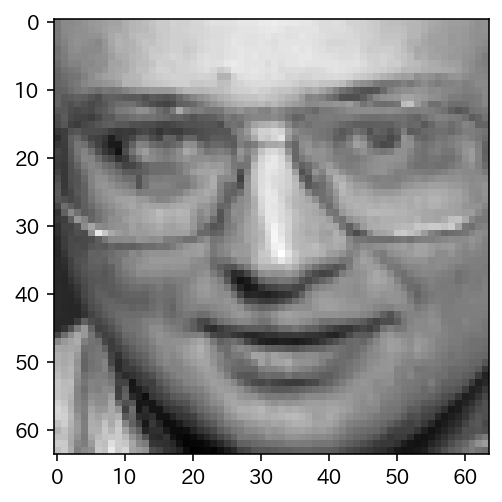

In [3]:
X__ = dfX2.to_numpy()
X_3 = X__[:,1:]

import matplotlib.pyplot as plt
plt.imshow(X_3[300].reshape(64,64), cmap='gray')
plt.show()

In [118]:
# X を n 行 m 列の行列として，列方向 m x m の相関係数行列を求める
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces()
X, y = data.data, data.target
x_bar = np.mean(X, axis=0)         # 各列の平均値を計算
X_bar = X - x_bar                  # 各列の平均値を減じて平均偏差ベクトルとする
Cov = X_bar.T @ X_bar / X.shape[0] # 共分散行列
X_std = np.std(X, axis=0)          # 各列の標準偏差
R = Cov / np.outer(x_std.T, x_std) # 共分散行列の各列を対応する標準偏差の積で除して相関係数行列にする
print(f'R.shape:{R.shape}')        # 確認用 相関係数行列のサイズ
print(f'R\n:{R[:3,:3]}')           # 確認用 相関係数行列の最初の 3 行 3 列を表示する

R2 = np.corrcoef(X.T)              # 上記を一行で行う numpy コマンド
print(f'R2\n:{R2[:3,:3]}')         # 結果の表示


def pca(X, n_dim = 5):
    """N 行 x D 列 の行列の PCA を実施"""
    (n, m) = X.shape  # 行列のサイズを取得
    #X = X - np.tile(np.mean(X, 0), (n, 1))  # X から
    X = X - np.mean(X, axis=0)
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:,0:n_dim])
    return Y

print(pca(X.T)[:3])



R.shape:(4096, 4096)
R
:[[1.0000005  0.94321746 0.8148688 ]
 [0.94321746 0.9999998  0.92443025]
 [0.8148688  0.92443025 1.0000005 ]]
R2
:[[1.         0.9432174  0.81486848]
 [0.9432174  1.         0.92443031]
 [0.81486848 0.92443031 1.        ]]
[[-2.7122397   2.1089826   0.7751158  -0.65840924 -0.15321301]
 [-1.9998541   2.2911568   0.46459854 -0.59731185 -0.16248769]
 [-1.0969465   2.4451737   0.09920788 -0.7813157  -0.07815776]]


In [116]:
x = np.array([[0, 2], [1, 1], [2, 0]]).T
#x = np.random.randn((10,3))
print(x)
#    array([[0, 1, 2],
#           [2, 1, 0]])

print(np.mean(x,axis=0))
print(np.tile(np.mean(x,0), (1,3)))

#    Note how :math:`x_0` increases while :math:`x_1` decreases. The covariance
#    matrix shows this clearly:
    
#np.cov(x)

[[0 1 2]
 [2 1 0]]
[1. 1. 1.]
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [57]:
D = np.diag(Cov)
DtD = np.outer(D.T, D) # D @ D.T
print(np.sqrt(DtD[:3,:3]))
print((Cov / np.sqrt(DtD))[:3,:3])

[[ 77.07059   83.170364  90.329445]
 [ 83.170364  89.75291   97.4786  ]
 [ 90.329445  97.4786   105.86929 ]]
[[1.        0.9905919 0.9705761]
 [0.9905919 1.        0.9883123]
 [0.9705761 0.9883123 1.       ]]


0 から 399 までの数字を一つ入力してください  300


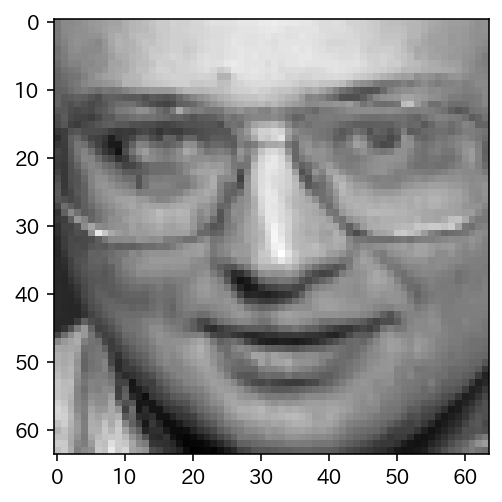

In [2]:
# n 番目の画像を表示してみましょう
n = int(input('0 から 399 までの数字を一つ入力してください ')) 
plt.imshow(X[n].reshape(64,64), cmap='gray')

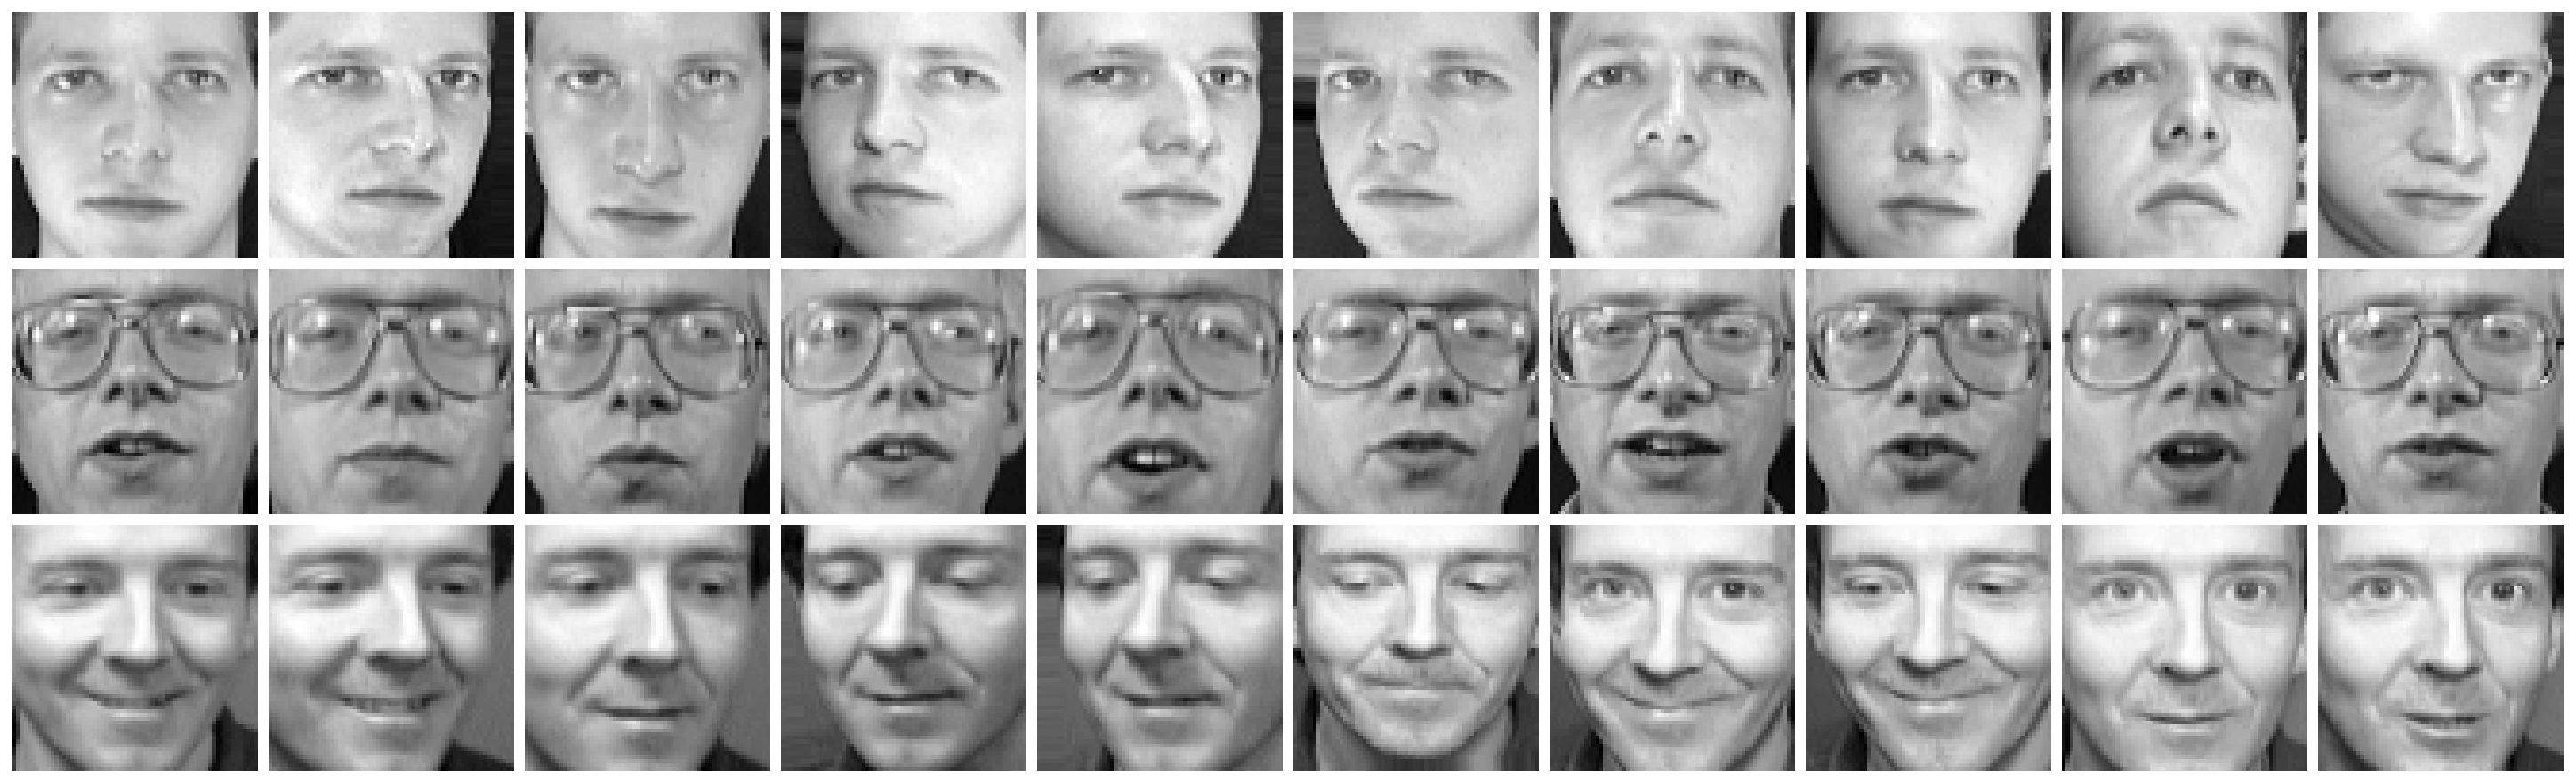

In [3]:
fig1, fig1_axes = plt.subplots(ncols=10, nrows=3, figsize=(20,6), constrained_layout=True)
# constrained_layout は subplot や 凡例やカラーバーなどの装飾を自動的に調整して，
# ユーザが要求する論理的なレイアウトをできるだけ維持しながら， 図ウィンドウに収まるようにします。

rows = 3 # rows 人分のデータを表示
for i in range(rows): 
    for j in range(10):
        x = i * 10 + j
        fig1_axes[i][j].imshow(X[x].reshape(64,64), cmap='gray')
        fig1_axes[i][j].axis('off')        

In [4]:
target = y
print("目標とするクラス(画像中の人物の数) :", np.unique(target))

目標とするクラス(画像中の人物の数) : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


# 1. 機械学習手法による顔認識

## 1.1 データの分割，訓練データとテストデータ

オリベッティ顔データセットには， 各被験者の 10 枚の顔画像が含まれています。
このうち，例えば 90% を訓練データとし，10% をテストデータとして使用することを考えます。
各顔データの訓練画像とテスト画像の数が同じになるように `stratify` 機能を使用してます。
したがって，各被験者には 9 枚の訓練用画像と 1 枚のテスト用画像が用意されることになります。
訓練データとテストデータの割合は `split_ratio` 変更することができます。

<font color="teal">
竹市先生のお言葉<br/>
たとえば，最初にデータを２つに割って，片方のデータセットで重回帰し，同じパラメータで残りのセットの重回帰がどのくらいいけるかを見る．ある程度だめでしょう．そこを，あえて不良設定にして制約条件をいれると，摩訶不思議なことに，片方のデータセットで重回帰したパラメータが残りのセットでもいけるようになる．２つに割る割り方を何通りか変えても同じ．
</font>

竹市先生の言葉を機械学習的に言い換えると，次のようになります。

* データを 2 分割して，訓練データセットとテストデータセットに分割します。
* 分割した訓練データセットでモデルのパラメータを学習し，しかる後に，テストデータセットで，その汎化性能を評価します。
* このとき，テストデータセットでの性能が高いモデルが良いモデルということになります。

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import seaborn as sns  # ヒートマップ描画のために使用します

# split_ratio = 0.1 としているので，訓練データ対テストデータが 8:2 になります
split_ratio = 0.5
X_train, X_test, y_train, y_test=train_test_split(X, target, test_size=split_ratio, stratify=target, random_state=0)
print(f'X_train 訓練画像のサイズ: {X_train.shape}')
print(f'y_train 教師信号データのサイズ: {y_train.shape}')

X_train 訓練画像のサイズ: (200, 4096)
y_train 教師信号データのサイズ: (200,)


## 分類手法の検討

訓練画像から人物が予測できるか否かを検討します。

In [ ]:
# 線形判別分析による予測
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)    # 訓練データを用いて線形判別分析モデルを訓練
y_hat = clf.predict(X_test)  # テストデータを使って予測を行い結果を y_hat に格納
print(f"線形判別分析を用いた分類精度: {metrics.accuracy_score(y_test, y_hat):.3f}")

# 混同行列の表示
plt.figure(1, figsize=(10,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_hat))

In [ ]:
clf = SVC()  # サポートベクターマシンを宣言
clf.fit(X_train, y_train)     # 訓練データを用いてサポートベクターマシンモデルを訓練
y_hat = clf.predict(X_test)  # テストデータを使って予測を行い結果を y_hat に格納
print(f"サポートベクターマシンを用いた分類精度: {metrics.accuracy_score(y_test, y_hat):.3f}")

# 混同行列の表示
plt.figure(figsize=(10,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_hat))

In [ ]:
# ロジスティック回帰による予測
log_reg = LogisticRegression(max_iter=10 ** 4)
log_reg.fit(X_train, y_train)    # 訓練データを用いて線形判別分析モデルを訓練
y_hat = log_reg.predict(X_test)  # テストデータを使って予測を行い結果を y_hat に格納
print(f"ロジスティック回帰を用いた分類精度: {metrics.accuracy_score(y_test, y_hat):.3f}")

# 混同行列の表示
plt.figure(figsize=(10,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_hat))

# 交差検証

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

for name, model in [['サポートベクターマシン', SVC()], 
                    ['線形判別分析', LinearDiscriminantAnalysis()],
                    ['ロジスティック回帰', LogisticRegression(max_iter= 10 ** 4)]]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print(f"{name} 平均交差検証得点: {cv_scores.mean():.2f}")

# 2. ニューラルネットワーク を用いた正則化項の検討

In [ ]:
print(f'y_train のサイズ: {y_train.shape}')
print(f'X_train のサイズ: {X_train.shape}')
n_classes = len(set(y_train))
print(f'n_classes: {n_classes}')

In [ ]:
import torch
import torch.nn as nn

X_ = torch.tensor(X_train).float()
y_ = torch.tensor(y_train).long()
Xtest_ = torch.tensor(X_test).float()
ytest_ = torch.tensor(y_test).long()
print(f'X_ のサイズ: {X_.size()}')
print(f'y_ のサイズ: {y_.size()}')
print(f'Xtest_ のサイズ: {Xtest_.size()}')
print(f'ytest_ のサイズ: {ytest_.size()}')


# 線形回帰モデルを PyTorch で定義
class lin_reg_Module(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.fc = nn.Linear(n_input, n_output, bias=True)

    def forward(self, x):
        y_hat = self.fc(x)
        return y_hat

# LinearModelのインスタンス作成
linreg_model = lin_reg_Module(n_input = X_.size(1),
                           n_output = n_classes)

# 回帰モデルの状態を表示
print(linreg_model.state_dict())

In [ ]:
import torch 
from torch import nn 

# 授業との関連で言えば，平均自乗誤差を用いるべきなのですが，後の発展的話題を
# 考慮して，損失関数として，交差エントロピー関数を用います
#loss_f = nn.MSELoss()         # 損失関数 平均自乗誤差
loss_f = nn.CrossEntropyLoss() # 損失関数 交差エントロピー
optimizer = torch.optim.Adam(params = linreg_model.parameters(), lr=0.01)

## 2.1 正則化項なし

In [ ]:
n_epochs = 50
loss_list = [] #損失関数の値を保存するためのリスト

reg_model0 = lin_reg_Module(n_input = X_.size(1),
                            n_output = n_classes)
reg_model0.fc.reset_parameters()
loss_f = nn.CrossEntropyLoss() # 損失関数 交差エントロピー
optimizer = torch.optim.Adam(params = reg_model0.parameters(), lr=0.01)

for epoch in range(n_epochs):
    y_hat = reg_model0(X_)    # 予測値の計算
    loss = loss_f(y_hat, y_)  # 損失関数の値を計算
    optimizer.zero_grad()     # 勾配を初期化
    loss.backward()           # 勾配を計算
    optimizer.step()          # パラメータを更新
    loss_list.append(loss.detach()) # 損失関数の値を保存


In [ ]:
import matplotlib.pyplot as plt

print(loss_list[-1])
plt.plot(loss_list)
plt.xlabel('反復訓練回数') 
plt.ylabel('損失値') 
plt.title('正則化項なし')
plt.show()

In [ ]:
reg_model0.eval()
y_pred_ = reg_model0(Xtest_)
y_pred = y_pred_.detach().numpy()
print(f"reg_model0 を用いた分類精度: {metrics.accuracy_score(y_test, np.argmax(y_pred,axis=1)):.3f}")

# 混同行列の表示
plt.figure(1, figsize=(10,8))
sns.heatmap(metrics.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

In [ ]:
# # 数値を表示してもあまり意味はありませんが，とりあえず
# # 確認します。
# print(reg_model0.fc.weight)  # 重み，あるいは結合係数行列と呼ばれる行列
# print(reg_model0.fc.bias)    # バイアス項，あるいは，切片 intercept と呼ばれる項です

In [ ]:
# # パラメータを一度初期化しておきます。
# reg_model0.fc.reset_parameters()
# print(reg_model0.fc.weight)
# print(reg_model0.fc.bias)

## 2.2 L1 正則化

In [ ]:
n_epochs = 50  # 反復学習回数
loss_list = [] # 損失値を保存しておくための格納領域
Lambda = 1 # 正則化パラメータ

reg_model1 = lin_reg_Module(n_input = X_.size(1),
                            n_output = n_classes)
reg_model1.fc.reset_parameters()
loss_f = nn.CrossEntropyLoss() # 損失関数 交差エントロピー
optimizer = torch.optim.Adam(params = reg_model1.parameters(), lr=0.01)

for epoch in range(n_epochs):
    y_hat = reg_model1(X_)
    loss = loss_f(y_hat, y_)

    # パラメータの L1 ノルムを損失関数に加えます
    l1 = torch.tensor(0., requires_grad=True)
    for w in reg_model1.parameters():
        l1 = l1 + torch.norm(w, 1)
        loss = loss + Lambda * l1

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.detach())

In [ ]:
print(loss_list[-1])
plt.plot(loss_list)
plt.xlabel('反復訓練回数') 
plt.ylabel('損失値') 
plt.show()

In [ ]:
reg_model1.eval()
y_pred_ = reg_model1(Xtest_)
y_pred = y_pred_.detach().numpy()
print(f"reg_model1 を用いた分類精度: {metrics.accuracy_score(y_test, np.argmax(y_pred,axis=1)):.3f}")

# 混同行列の表示
plt.figure(1, figsize=(10,8))
sns.heatmap(metrics.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

## 2.3 L2 正則化

In [ ]:
epochs = 50
loss_list = []
Lambda = 0.01 # 正則化パラメータ

reg_model2 = lin_reg_Module(n_input = X_.size(1),
                            n_output = n_classes)
reg_model2.fc.reset_parameters()
loss_f = nn.CrossEntropyLoss() # 損失関数 交差エントロピー
optimizer = torch.optim.Adam(params = reg_model2.parameters(), lr=0.001)

for epoch in range(epochs):
    y_hat = reg_model2(X_)
    loss = loss_f(y_hat, y_)

    # L2 ノルムの二乗を損失関数に加える
    l2 = torch.tensor(0., requires_grad=True)
    for w in reg_model2.parameters():
        l2 = l2 + torch.norm(w) ** 2
        loss = loss + Lambda * l2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.detach())

In [ ]:
print(loss_list[-1])
plt.plot(loss_list)
plt.xlabel('反復訓練回数') 
plt.ylabel('損失値') 
plt.show()

In [ ]:
reg_model2.eval()
y_pred_ = reg_model2(Xtest_)
y_pred = y_pred_.detach().numpy()
print(f"reg_model2 を用いた分類精度: {metrics.accuracy_score(y_test, np.argmax(y_pred,axis=1)):.3f}")

# 混同行列の表示
plt.figure(1, figsize=(10,8))
sns.heatmap(metrics.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

# より多くの検証結果を得るための リーブ・ワン・アウト 交差検証

オリベッティ顔データセットには，各被験者に対して 10 枚の顔画像が含まれています。 これは， 機械学習モデルの学習やテストには少ない数です。

クラスの例が少ない機械学習モデルをよりよく評価するために， 採用される交差検証法にリーブ・ワン・アウト leave-one-out (LOO) 交差検証法があります。 LOO 法では，あるクラスのサンプルのうち 1 つだけをテストに使用します。 他のサンプルは訓練に使用します。 この手順を， 全サンプルを一度づつテストに使用して繰り返さします。

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo_cv = LeaveOneOut()
clf = LinearDiscriminantAnalysis()
cv_scores = cross_val_score(clf,
                            X_train,
                            y_train,
                            cv = loo_cv)

print(f"{clf.__class__.__name__} リーブ・ワン・アウト交差検証法による平均得点:{cv_scores.mean():.3f}")

In [ ]:
#help(clf.__class__)
#dir(clf)  # .__class__) #.coef_)
#dir(clf.__class__) # n_components) #_get_param_names())
# coef_ 
# intercept_
# covariance_ 
cv_scores

# ハイパーパラメータの調整。GridSearcCV

モデルの汎化性能向上のために GridSearchCV を行います。 ロジスティック回帰分類器のハイパーパラメータを調整してみます

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

params={'penalty':['l1', 'l2'],
        'C':np.logspace(0, 4, 10) }
clf = LogisticRegression()
loo_cv = LeaveOneOut()
gridSearchCV = GridSearchCV(clf, params, cv=loo_cv)
gridSearchCV.fit(X_train, y_train)
print("Grid search fitted..")
print(gridSearchCV.best_params_)
print(gridSearchCV.best_score_)
print(f"グリッドサーチによる交差妥当性得点:{gridSearchCV.score(X_test, y_test):.3f}")

# 精度ー再現率 - ROC曲線

精度ー再現率曲線は 2 値分類の場合です。 オリベッティ顔データセットでは 40 の異なるクラス (40人分の顔画像) があります。

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

Target = label_binarize(target, classes=range(40))
n_classes = Target.shape[1]
X_train_multiclass, X_test_multiclass, \
y_train_multiclass, y_test_multiclass = train_test_split(X, 
                                                         Target,
                                                         test_size=0.2,
                                                         stratify=Target,
                                                         random_state=0)

oneRestClassifier = OneVsRestClassifier(clf)
oneRestClassifier.fit(X_train_multiclass, y_train_multiclass)
y_score = oneRestClassifier.decision_function(X_test_multiclass)

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_multiclass[:, i], y_score[:, i])
    average_precision[i] = metrics.average_precision_score(y_test_multiclass[:, i], y_score[:, i])

precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_test_multiclass.ravel(), y_score.ravel())
average_precision["micro"] = metrics.average_precision_score(y_test_multiclass, y_score, average="micro")
print(f'平均精度得点, 全クラスの平均: {average_precision["micro"]:0.3f}')

In [ ]:
#!pip install install funcsigs
from funcsigs import signature 

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(1, figsize=(12,8))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [ ]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


class VAE(nn.Module):
    def __init__(self, data_dim=4096, z_dim=32, hidden_dim=100):
        """
        VAE basic model.
        Args:
            data_dim (int): dimension of flatten input
            z_dim (int): dimension of manifold
            hidden_dim (int): dimension of hidden layers between input and manifold
        """
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(data_dim, hidden_dim)
        self.hidden2mu = nn.Linear(hidden_dim, z_dim)
        self.hidden2log_var = nn.Linear(hidden_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, data_dim)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.hidden2mu(h1), self.hidden2log_var(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def reparam(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparam(mu, log_var)
        return self.decode(z), mu, log_var


def train(data_loader, model, loss_func, epoch):
    model.train()
    train_loss = 0
    for batch_i, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_func(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_i % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_i * len(data), len(data_loader.dataset),
                       100. * batch_i / len(data_loader),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(data_loader.dataset)))


def test(data_loader, model, loss_func):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, log_var = model(data)
            test_loss += loss_func(recon_batch, data, mu, log_var).item()

    test_loss /= len(data_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
data = fetch_olivetti_faces()
X, y = data.data, data.target

from sklearn.model_selection import train_test_split
# split_ratio = 0.1 としているので，訓練データ対テストデータが 8:2 になります
split_ratio = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, target, 
                                                    test_size=split_ratio, 
                                                    stratify=target, 
                                                    random_state=0)
print(f'X_train 訓練画像のサイズ: {X_train.shape}')
print(f'y_train 教師信号データのサイズ: {y_train.shape}')

X_ = torch.tensor(X_train).float()
y_ = torch.tensor(y_train).long()
Xtest_ = torch.tensor(X_test).float()
ytest_ = torch.tensor(y_test).long()


from torch.utils.data import Dataset, DataLoader

class FaceDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return X[idx]
    
train_face_data = FaceDataset(X_, y_)
train_dataloader = DataLoader(train_face_data, batch_size=len(train_face_data), shuffle=True, num_workers=1, drop_last=True)

test_face_data = FaceDataset(Xtest_, ytest_)
test_dataloader = DataLoader(test_face_data, batch_size=len(test_face_data), shuffle=False, num_workers=1, drop_last=True)

In [ ]:
# # Create directory for resulting images
# if not os.path.exists('results/reconstruction'):
#     os.makedirs('results/reconstruction')

def vae_loss_f(x_reconstructed, x, mu, log_var):
    """
    Loss function for VAE
    Args:
        x_reconstructed (torch.Tenor): decoder output [batch_size, input_size]
        x (torch.Tensor): input data [batch_size, input_size]
        mu (torch.Tensor): [batch_size, z_dim]
        log_var (torch.Tensor): [batch_size, z_dim]

    Returns (torch.Tensor): tensor of single loss value
    """
    # Reconstruction loss
    bce = F.binary_cross_entropy(x_reconstructed, x.view(-1, input_dim), reduction="sum")

    # KL divergence
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kld


In [ ]:
np.random.seed(2021)
torch.manual_seed(2021)

config = {
    'epochs': 50,
    'z_dim': 30,
    'input_dim': 4096,
    'hidden_dim': 32,
    'batch_size': 200,
    'lr': 0.001,
}

epochs = config['epochs']
batch_size = config['batch_size']
input_dim = config['input_dim']
z_dim = config['z_dim']
hidden_dim = config['hidden_dim']
lr = config['lr']

vae_model = VAE(input_dim, z_dim, hidden_dim).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    train(train_dataloader, vae_model, vae_loss_f, epoch)
    test(test_dataloader, vae_model, vae_loss_f)
    with torch.no_grad():
        sample = torch.randn(20, z_dim).to(device)
        sample = model.decode(sample).cpu()
